<h2><font color = 'Grey'> Plano de análise: Sistema de Recomendação de Livros<font color></h2>

**Author :** Alcides Gabriel

**E-mail :** alcidesgabriel.ds@gmail.com

**Task :** <font color='grey'> Desenvoler um sistema de recomendação híbrido (Baseado em conteúdo e Colaboração) </font>

[Fonte de dados: Kaggle](https://www.kaggle.com/datasets/saurabhbagchi/books-dataset)

- **Qual sistema de recomendação utilizar?**
  - O modelo híbrido é muito utilizado em grades empresas de E-commerce, no qual ele mescla os 3 tipos de sistema de recomendação: Baseado em Conteúdo, Colaboração e Conhecimento, sendo muito usado uma mescla do Conteúdo com Colaboração(será usado aqui).

- **Como avaliar um sistema de recomendação?**
  - Fora a comparação entre antes e depois da implementação do sistema de recomendação, é possível fazer simulações onde se espera certas respostas do modelo de Machine Learning.
  - Aqui será usado como base de recomendação o livro da saga Harry Potter, por ser um livro conhecido mundialmente e ter mais de 5 livros, pode-se esperar que as recomendações venham em torno da saga.

- **O que esperar do sistema de recomendação?**
  - Como será abordado 2 tipos de sistemas de recomendação, se espera que o de Conteúdo indique a saga de harry potter e livros relacionados a ele; Já no sistema baseado em colaboração, se espera que além da recomendação dos livros da saga ele traga livros diferentes, visto que será feito uma separação por tipo de consumidores.

- **Qual o maior limitante na base de dados?**
  - Como os livros não apresentam o gênero, o sistema acaba sendo limitado em suas recomendações, baseando somente nos livros comprados pelos usuários.


# Importação 


## Bibliotecas

In [ ]:
# Importação Básica.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import FontProperties
import seaborn as sns

# Importação Base Para o ML.
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import LabelEncoder


## Dataset

In [ ]:
books = pd.read_csv('.../Books.csv')
rating = pd.read_csv('.../Ratings.csv')
users = pd.read_csv('.../Users.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Tratamento dos dados


## Users

In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
# Renomear Colunas
users.columns = ['user_id','location','age']

In [ ]:
# Separar coluna Location
location = users['location'].str.split(',',2,True)
location.columns = ['city','state','country']
location.head()

,city,state,country
0,nyc,new york,usa
1,stockton,california,usa
2,moscow,yukon territory,russia
3,porto,v.n.gaia,portugal
4,farnborough,hants,united kingdom


In [ ]:
# Atualizar dados de usuários
users = pd.concat([users,location], axis=1).drop('location',axis=1)

In [ ]:
users.head()

,user_id,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [ ]:
def limpeza(x):
  """
  ------
  x : int
    Como a quantidade de Informações e vázios é abundante, transformar esses
    dados em uma faixa etária pode facilitar o modelo.
  ------

  """


  if x < 18:
    return 'Menor de idade'
  elif (x>=18) & (x <= 29):
    return 'Jovem'
  elif (x>=30) & (x <= 59):
    return 'Adulto'
  elif x >= 60:
    return 'Idoso'
  else:
    return 'Não informado'

# Aplicando a função
users['age'] = users['age'].apply(lambda x: limpeza(x))

In [ ]:
users.head()

,user_id,age,city,state,country
0,1,Não informado,nyc,new york,usa
1,2,Jovem,stockton,california,usa
2,3,Não informado,moscow,yukon territory,russia
3,4,Menor de idade,porto,v.n.gaia,portugal
4,5,Não informado,farnborough,hants,united kingdom


In [ ]:
print(f' Um total de {users.shape[0]} cadastrados')

 Um total de 278858 cadastrados


## Ratings


In [ ]:
# Renomear coluna das avaliações
rating.columns = ['user_id','ISBN','nota']
rating

,user_id,ISBN,nota
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
rating['nota'].describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: nota, dtype: float64

In [ ]:
print(f'A quantidade de livros avaliados foi de: {rating["ISBN"].value_counts().shape[0]}')

A quantidade de livros avaliados foi de: 340556


## Books

In [ ]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


## Transformação dos dados

In [ ]:
# Junção de dados.
teste = rating['user_id'].value_counts()
teste = pd.DataFrame({'user_id':teste.index, 'Avaliations':teste})
teste_1 = users.copy()
aval_1 = pd.merge(teste_1, teste, on='user_id', how='left').fillna(0)

In [ ]:
# Transformar dados categóricos em numéricos.
aval_lb = aval_1.copy()
for i in ['age','city','state','country']:
  aval_lb[i] = LabelEncoder().fit_transform(aval_lb[i].astype(str))

# Divisão dos dados
transformer = IncrementalPCA(n_components=2, batch_size=400)
pca = transformer.fit_transform(aval_lb.drop("user_id",axis=1))
pca = pd.DataFrame(pca)
pca.columns = ['c0','c1']

# Cluster usando Gaussian

  ## PCA
gmm = GaussianMixture(n_components=20)
gmm.fit(pca)
grupos = gmm.predict(pca)
pca['cluster'] = grupos


  ## Base dados
gmm2 = GaussianMixture(n_components=20)
gmm2.fit(aval_lb.drop('user_id',axis=1) )
pca['cluster_2'] = gmm2.predict(aval_lb.drop('user_id',axis=1))


# Adicionar infos na base de dados.

aval_2 = aval_1.copy()
aval_2['cluster'] = pca['cluster']
aval_2['cluster_2'] = pca['cluster_2']

# Criando uma tabela com 1's para registrar que foi comprado.
rating['comprado'] = rating['nota'].apply(lambda x: 1)

# Junção do rating com info dos usuários
aval_3 = rating.merge(aval_2, on='user_id')

# Edição do dataset Books
livros = books.copy()
livros = livros.drop(livros.columns.tolist()[5:], axis=1)

# Inserindo a quantidade de livros avaliados.
passagem = pd.DataFrame()
passagem['ISBN'] = rating['ISBN'].value_counts().index
passagem['avaliations'] = rating['ISBN'].value_counts().values
livros = livros.merge(passagem, on='ISBN')

# Filtro da quantiade de avaliações mínima dos livros
f_livros = livros.loc[livros['avaliations'] > 50]
f_livros.columns = ['ISBN','title','author','year','publisher','avaliations']

# Filtro de quantidade de avaliações
f_us_ra = aval_2.loc[aval_2['Avaliations'] >= 20]

# Junção do rating com os users
f_us_ra = rating.merge(f_us_ra, on='user_id')

# Junção final
f_final = f_us_ra.merge(f_livros, on='ISBN')

# Modelo de Machine Learning

In [ ]:
def tabela(df,titulo):
  """
  Função retorna uma tabela contendo as informações de livros recomendados

  ---------
  df : DataFrame
    Livros recomendados.
  titulo : string
    Nome do livro base.
  ---------

  """
  # Tamanho da imagem
  plt.figure(figsize=(30,13))
  # Título da imagem
  plt.title(f'Livro Comprador Anteriormente:     {titulo}', fontsize=30, horizontalalignment='left', x=0)
  # Desativar axis  (x,y)
  plt.axis('off')

  ## Criação da tabela 
  tabela = plt.table(cellText = df.values, colLabels=df.columns,
                         loc='center', cellLoc='center', colLoc='center',rowLoc='right', 
                     bbox=[0.1,0.2,0.8,0.6], # Posição do box da tabela, assim como o tamanho de cada cell
                     edges='vertical') # Qual edges manter.

  # Ajuste de tabela.
  tabela.auto_set_column_width(col=list(range(len(df.columns))))
  tabela.scale(10, 10)
  ## Mudando cores na tabela
  for ro in range(df.shape[0]):
    for core in range(3):
      tabela[(ro+1,core)].get_text().set_color('grey')

  for (r,c), cell in tabela.get_celld().items():
    if (r == 0):
      cell.set_text_props(fontproperties = FontProperties(weight='bold'))
  # Configuração de fonte 
  tabela.auto_set_font_size(False)
  tabela.set_fontsize(14)


In [ ]:
def recom_sys(usuario, df_entrada):
  """
  Função de recomendação de livros.

  ---------
  usuario : int
    Número do índice do usuário oriundo da base de dados contendo as infos de: cluster e titulo.
  df_entrada : DataFrame
    Dataset final contendo todas as avaliações de livros, rating e usuários.
  ---------

  """
  # Coleta dos dados de título e classificação do cluster
  infos = df_entrada.iloc[usuario]
  titulo = infos.title
  cluster_2 = infos.cluster_2
  cluster = infos.cluster
  print(f'Livro comprado pelo usuário: {titulo}\n')

  base_resultado = pd.DataFrame()

  for i in ['original','cluster_1','cluster_2']:
  # if para definir o tipo de DF que será passado no modelo
    if i == 'original':
      df = df_entrada
    elif i == 'cluster_1':
      df = df_entrada.loc[df_entrada['cluster'] == cluster]
    elif i == 'cluster_2':
      df = df_entrada.loc[df_entrada['cluster_2'] == cluster_2]

    # pivot -> Sparser -> Modelo -> livros mais próximos.
    pivot = df.pivot_table(index='title',columns='user_id',values='comprado').fillna(0)
    sparser = csr_matrix(pivot)
    model = NearestNeighbors(algorithm='brute')
    model.fit(sparser)
    distances, suggestions = model.kneighbors(pivot.loc[pivot.index == titulo].values.reshape(1,-1), n_neighbors=6)
    # Lista dos Livros.
    lista_top = pivot.index[suggestions[0]].tolist()
    lista_top.remove(titulo)

    base_resultado[i] = lista_top

  tabela(base_resultado, titulo)
  return base_resultado


# Avaliação de Resultado

## Livro de entrada: 'Harry Potter and the Chamber of Secrets (Book 2)'

### Levantamento de usuários para teste

- Levantar quais livros de harry potter estão presentes no dataset assim como levantar o nome desse livro.
- Selecionar alguns usuários de diferentes clusters para avaliar o retorno de recomendações.


In [ ]:
f_final.loc[f_final['title'].str.contains('Harry Potter'),'title'].unique()

array(['Harry Potter and the Chamber of Secrets (Book 2)',
       "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       "Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)'], dtype=object)

In [ ]:
f_final.loc[f_final['title'] == "Harry Potter and the Chamber of Secrets (Book 2)"].head(50)

,user_id,ISBN,nota,comprado,age,city,state,country,Avaliations,cluster,cluster_2,title,author,year,publisher,avaliations
3534,276929,0439064864,0,1,Adulto,collex,geneva,switzerland,79.0,17,10,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3535,254,0439064864,9,1,Jovem,minneapolis,minnesota,usa,314.0,7,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3536,1903,0439064864,0,1,Adulto,hualien,taiwan,taiwan,169.0,15,6,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3537,2033,0439064864,9,1,Jovem,omaha,nebraska,usa,198.0,1,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3538,6431,0439064864,10,1,Adulto,wylie,texas,usa,56.0,15,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3539,8529,0439064864,10,1,Não informado,logroño,la rioja,spain,80.0,18,10,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3540,8681,0439064864,0,1,Adulto,orlando,florida,usa,358.0,16,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3541,9357,0439064864,0,1,Não informado,quechee,vermont,usa,33.0,15,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3542,11676,0439064864,10,1,Não informado,n/a,n/a,n/a,13602.0,7,6,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170
3543,13273,0439064864,0,1,Idoso,harrisburg,pennsylvania,usa,465.0,11,7,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170


### Usuárioes selecionados: 

- 276929 (indice = 3534)
- 254 (indice = 3535)
- 11676 (indice = 3542)
- 100906 (indice = 3582)

Livro comprado pelo usuário: Harry Potter and the Chamber of Secrets (Book 2)



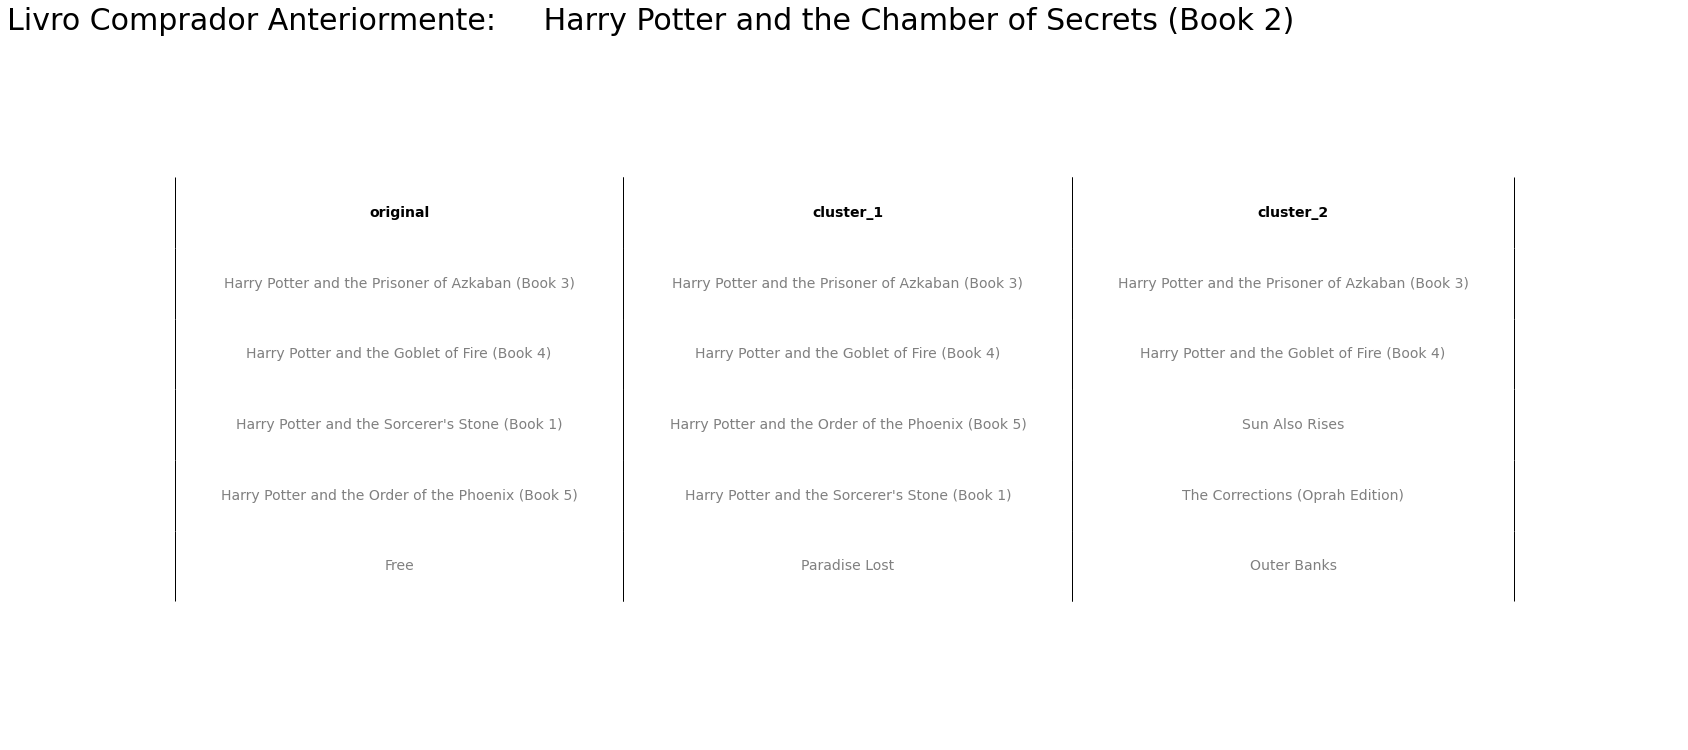

In [ ]:
teste = recom_sys(3534, f_final)

Livro comprado pelo usuário: Harry Potter and the Chamber of Secrets (Book 2)



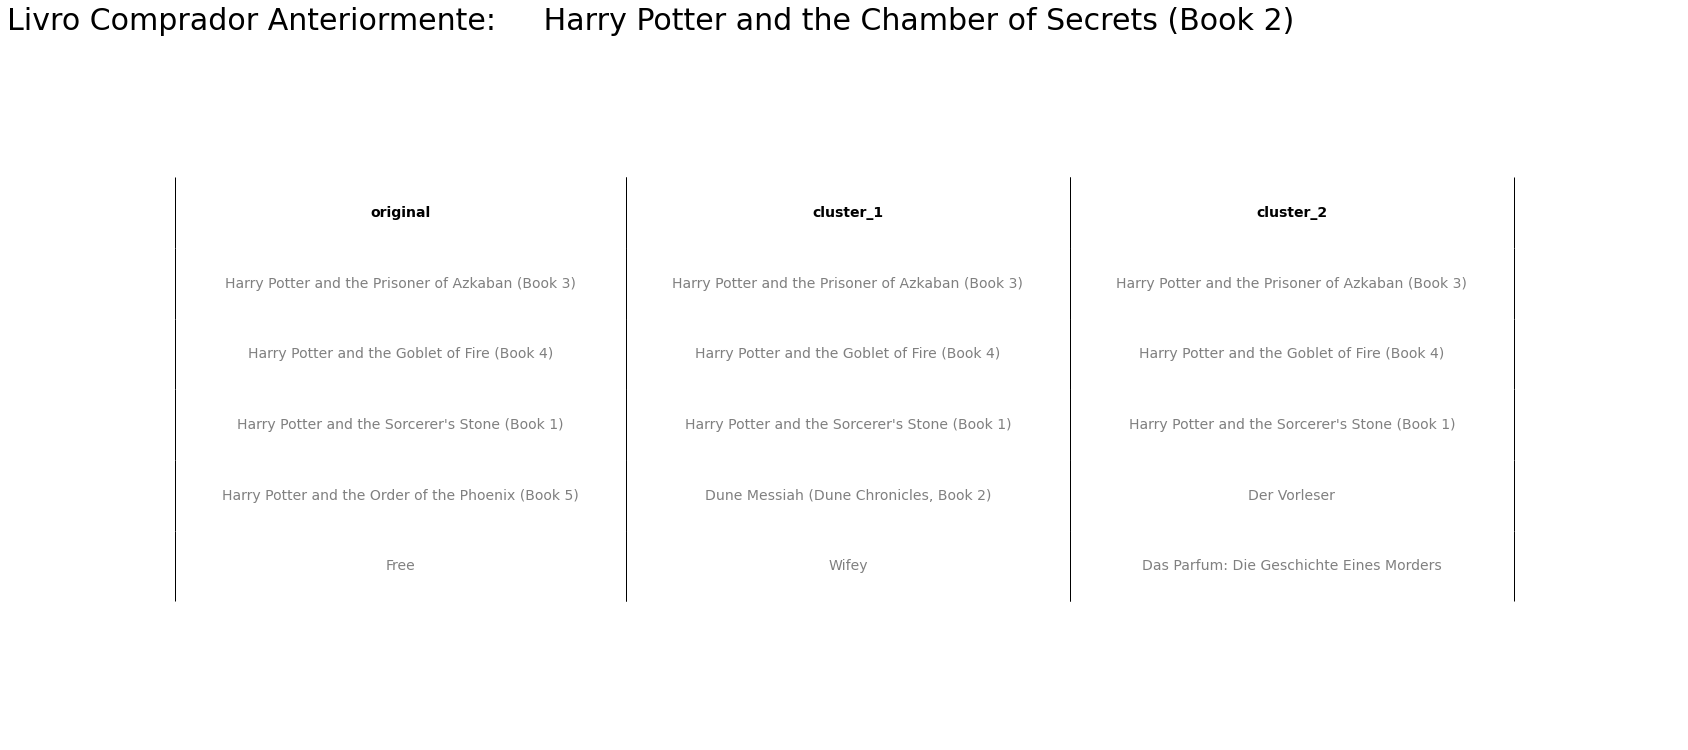

In [ ]:
teste = recom_sys(3535, f_final)

Livro comprado pelo usuário: Harry Potter and the Chamber of Secrets (Book 2)



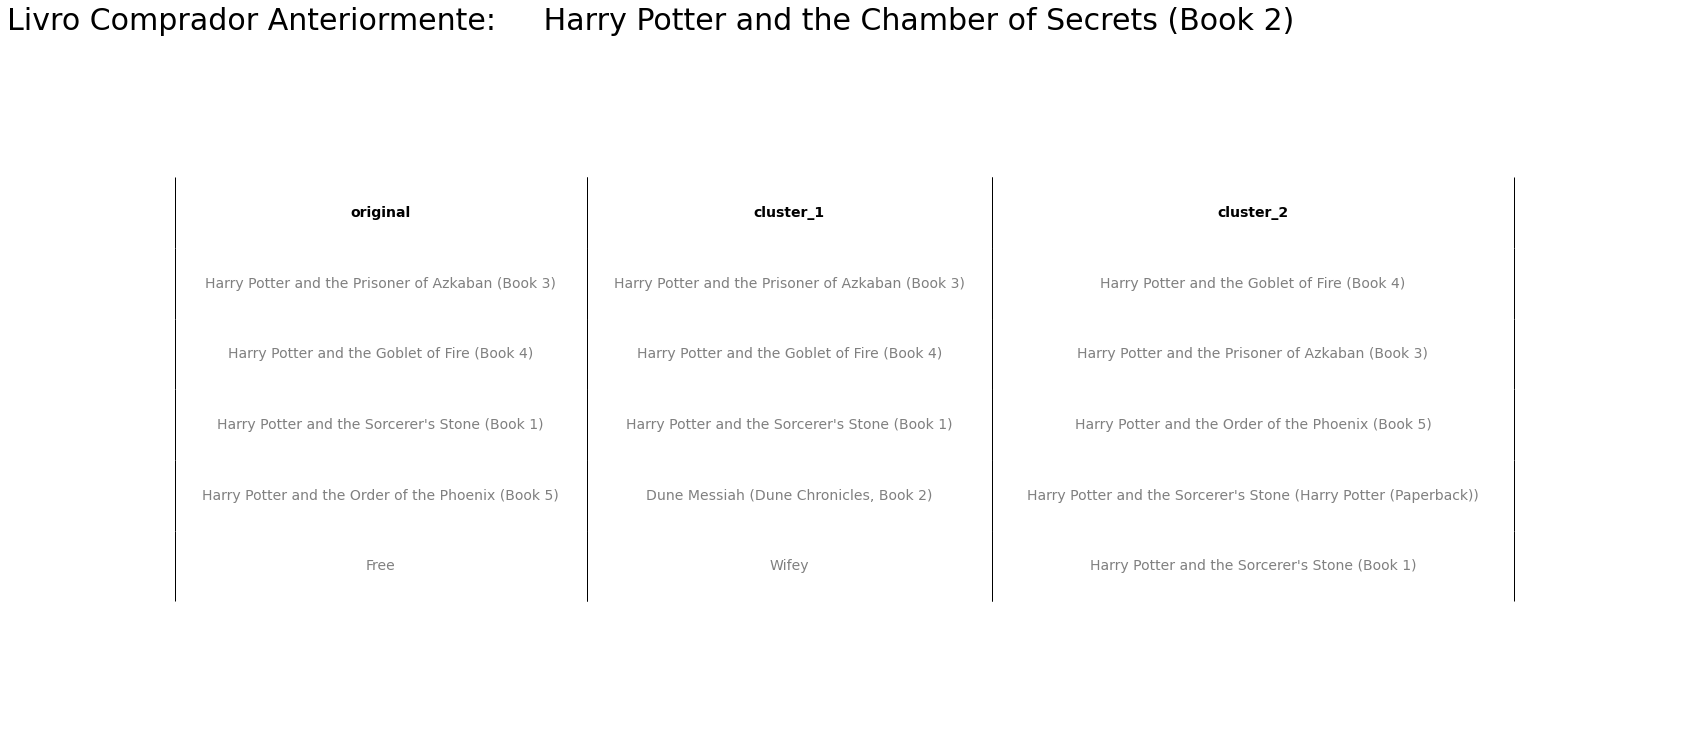

In [ ]:
teste = recom_sys(3542, f_final)

Livro comprado pelo usuário: Harry Potter and the Chamber of Secrets (Book 2)



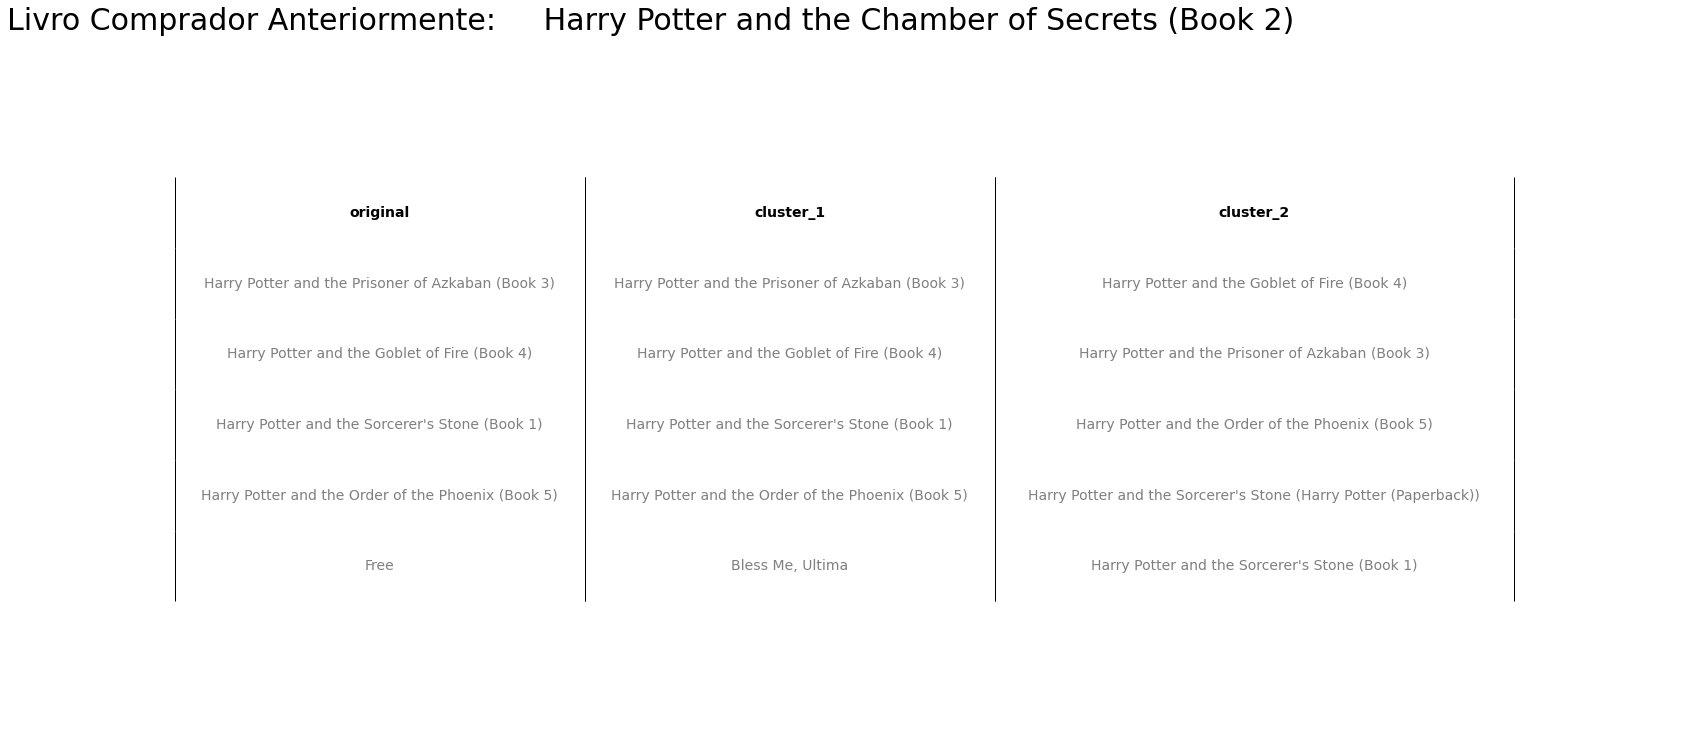

In [ ]:
teste = recom_sys(3582, f_final)

<h1> Análise dos resultados </h1>

- <h2> Recomendação Direta </h2>

  - A recomendação direta com base somente nos dados de compra foi bem satistatório, visto que da saga de livros ele recomendou o anterior e 3 livros após o comprado, já a última recomendação do último livro foge um pouco do estilo de livro original, mas foi encontrado uma correlação entre eles.

- <h2> Usuário 276929 </h2>
  
  - A recomendação do cluster pca foi bem satisfatória, visto que ele recomendou logo as 3 sequências dos livros para depois recomendar o livro anterior. Sobre o último livro recomendado é um livro de suspense, também aparenta não ter correlação com a saga original, mas houve alguma correlação.
  - A recomenda do cluster da base de dados dos usuários mostrou a recomendação dos 2 livros da saga em sequência e ofereceu mais 3 opções de livros, no qual contém um romance, outro de um tipo de novela fictícia e outro de algo parecido com o anteior.
  - Interessante que aqui mesmo com o gênero dos livros da saga de harry potter, outros gêneros foram recomendados para o usuário com base no cluster, outros gêneros que provavelmente se encaixam melhor ao gosto do usuário.

- <h2> Usuário 254 </h2>

  - Novamente o cluster pca mostrou um resultado muito bom em indicar as 2 sequências de harry potter e o anteior, mas adicionando mais um livro de saga que pode ser interessante para o usuário. O outro livro adicionado pode ser algo que se encaixe bem com o usuário, que foge bem do estilo dos tipos de livros indicados anteriormente por esse cluster.
  - O cluster da base dos usuários mostrou um resultado bem interessante, apontando os 2 próximos livros da saga, assim como o anterior, além de indicar 2 livros de romance que aparetam ser menos fantasioso, puxando para o drama. 


- <h2> Usuário 11676 </h2>

  - O cluster pca apresentou o mesmo resultado que o usuário anterior.
  - Já para o cluster a base dos usuários demonstrou que esse usuário específico é do grupo que realmente gosta da saga, assim recomendando todos os livros disponíveis sobre harry potter na base de dados.

- <h2> Usuário 100906 </h2>

  - O cluster pca indicou ao usuário um resultado satisfatório sobre a saga do harry potter, além de acrescentar um romance aclamado internacionalmente.
  - O cluster de base dos usuárioes apresentou o mesmo resultado que o anterior.


<h1> Conclusão </h1>

- **Recomendação com base colaborativa**: Apresentou um resultado muito satisfatório, visto que recomendou os outros livros da saga, mas recomendando um filme que fugiu um pouco do que seria esperado.
- **Recomendação com base em conteúdo**: Esse tipo de sistema de recomendação visa justamente ter uma indicação de produtos personalizada, na qual o usuário pode adquirir um produto, e acredito que esse resultado foi alcançado pelos 2 modelos de cluster, no qual além de indicar livros da saga, também livros personalizados de outros temas bem diferentes foram indicados pelos 2 modelos, ou seja, a personalização esperada com o sistema de recomendação foi alcançado.
- **Sendo assim um trabalho de pesos poderia ser feito para seleção de certos livros dos 3 modelos de indicação, além de outros modelos de cluster baseados em outros calculos podem ser utilizados.**